In [1]:
import sys
sys.path.append("..")

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from src.model import create_model
from src.transform import Transform
from sklearn.decomposition import PCA
from src.monitor import DomainShiftMonitor
from src.dataset import InferenceDataset, TrainDataset

In [ ]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

In [116]:
model = create_model(
    model_name="resnet18",
    pretrained=True,
    num_classes=10,
)

> Created resnet18 with pretrained weights. Num classes set to 10.


In [117]:
imagenette_dataset = TrainDataset(
    root_dir="/Users/riccardomusmeci/Developer/data/github/imagenette2-320",
    train=True,
    class_map={
        0: 'n03888257-parachute',
        1: 'n02979186-player',
        2: 'n03417042-truck',
        3: 'n03425413-distributor',
        4: 'n03445777-ball',
        5: 'n03028079-church',
        6: 'n02102040-dog',
        7: 'n01440764-fish',
        8: 'n03394916-trumpet',
        9: 'n03000684-chainsaw'
    },
    max_samples_per_class=3000,
    random_samples=True,
    transform=Transform(train=False, img_size=224)
)

> Train dataset sanity check OK
 ----------- Dataset Train Stats -----------
> ['n03888257-parachute'] : 960/9469 -> 10.138%
> ['n02979186-player'] : 993/9469 -> 10.487%
> ['n03417042-truck'] : 961/9469 -> 10.149%
> ['n03425413-distributor'] : 931/9469 -> 9.832%
> ['n03445777-ball'] : 951/9469 -> 10.043%
> ['n03028079-church'] : 941/9469 -> 9.938%
> ['n02102040-dog'] : 955/9469 -> 10.086%
> ['n01440764-fish'] : 963/9469 -> 10.170%
> ['n03394916-trumpet'] : 956/9469 -> 10.096%
> ['n03000684-chainsaw'] : 858/9469 -> 9.061%
 -------------------------------------


In [118]:
imagewang_dataset = TrainDataset(
    root_dir="/Users/riccardomusmeci/Developer/data/github/imagewang",
    train=True,
    class_map={
        0: 'n02086240',
        1: 'n02087394',
        2: 'n02088364',
        3: 'n02089973',
        4: 'n02093754',
        5: 'n02096294',
        6: 'n02099601',
        7: 'n02105641',
        8: 'n02111889',
        9: 'n02115641'
    },
    max_samples_per_class=3000,
    random_samples=True,
    transform=Transform(train=False, img_size=224)
)

> Train dataset sanity check OK
 ----------- Dataset Train Stats -----------
> ['n02086240'] : 142/1275 -> 11.137%
> ['n02087394'] : 119/1275 -> 9.333%
> ['n02088364'] : 141/1275 -> 11.059%
> ['n02089973'] : 75/1275 -> 5.882%
> ['n02093754'] : 146/1275 -> 11.451%
> ['n02096294'] : 147/1275 -> 11.529%
> ['n02099601'] : 127/1275 -> 9.961%
> ['n02105641'] : 126/1275 -> 9.882%
> ['n02111889'] : 138/1275 -> 10.824%
> ['n02115641'] : 114/1275 -> 8.941%
 -------------------------------------


In [119]:
monitor = DomainShiftMonitor(
    model=model,
    datasets=[imagenette_dataset, imagewang_dataset],
    target_layers="layer4.1.act2",
)

> Creating model monitor to get embeddings at specific layers.
[SUCCESS] Layer 'layer4.1.act2' found!


In [120]:
layers_dist = monitor.estimate()

> Extracting embedding for the first dataset.


100%|██████████| 296/296 [00:52<00:00,  5.63it/s]


> Extracting embedding for the second dataset.


100%|██████████| 40/40 [00:09<00:00,  4.12it/s]


> Estimating domain shift for layer: layer4.1.act2
> Dataset 1 embedding shape: (9469, 512)
> Dataset 2 embedding shape: (1275, 512)
Representation shift using wasserstein distance:  0.0343354916458331


In [87]:
layers_dist.keys()

dict_keys(['layer4.1.act2'])

In [88]:
X, y = layers_dist["layer4.1.act2"].values()
X.shape, y.shape

((10696, 512), (10696,))

In [94]:
red_method = TSNE(2, perplexity=15, learning_rate=200, random_state=42)
#red_method = PCA(2)

In [95]:
X_red = red_method.fit_transform(X)
X_red.shape

(10696, 2)

In [123]:
X_red[:, 0] = scale_to_01_range(X_red[:, 0])
X_red[:, 1] = scale_to_01_range(X_red[:, 1])

In [124]:
plot_df = pd.DataFrame(
    columns=['x1', 'x2', 'dataset'],
    data=np.column_stack((X_red, y))
)

# # cast targets column to int
plot_df.loc[:, 'dataset'] = plot_df.dataset.astype(int)
plot_df.loc[:, 'target'] = plot_df.dataset.map({0: "imagenette", 1: "imagewang"})
plot_df.head()

/var/folders/7m/lptk87z555zdlnjl_5y2w2dc0000gn/T/ipykernel_11635/2531617651.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  plot_df.loc[:, 'dataset'] = plot_df.dataset.astype(int)


,x1,x2,dataset,target
0,0.104009,0.291992,0,imagenette
1,0.262738,0.263477,0,imagenette
2,0.280022,0.662443,0,imagenette
3,0.169808,0.182587,0,imagenette
4,0.084858,0.449134,0,imagenette


/Users/riccardomusmeci/Developer/code/github/classifier-playground/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/riccardomusmeci/Developer/code/github/classifier-playground/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


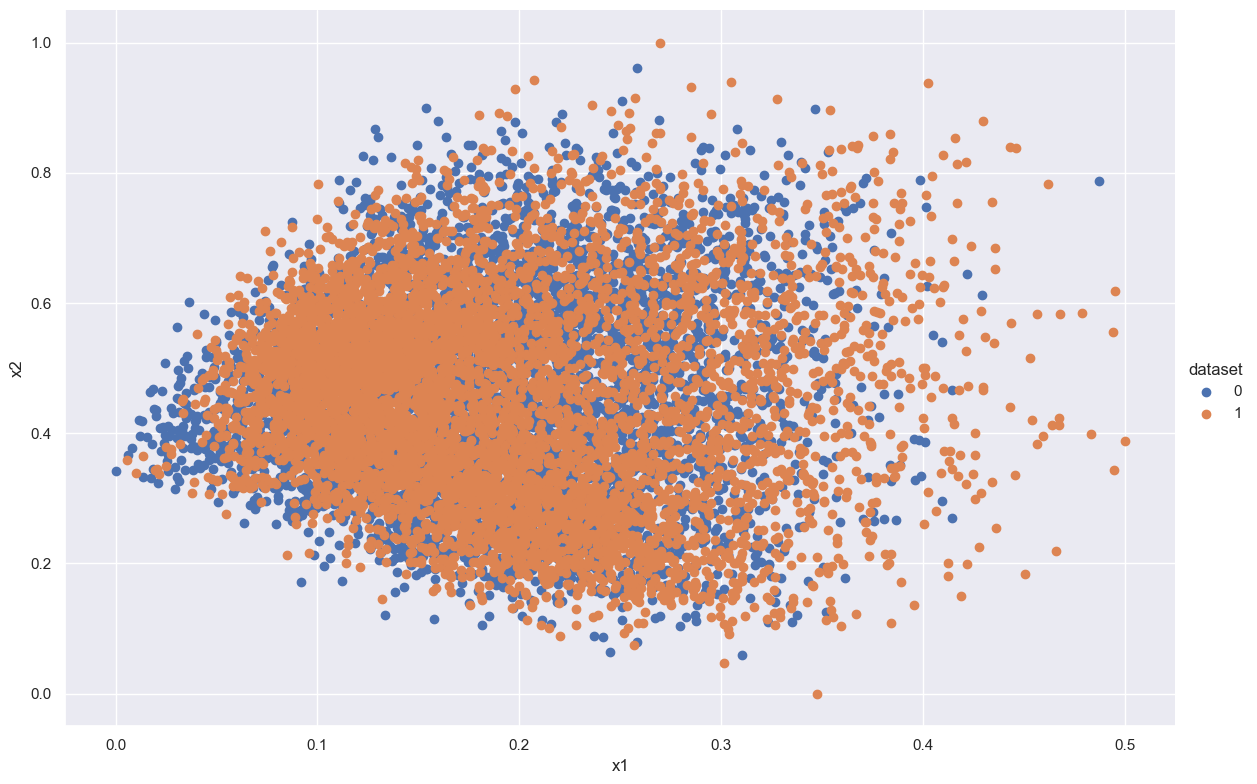

In [125]:
grid = sns.FacetGrid(plot_df, hue="dataset", height=8, aspect=1.5)
grid.map(plt.scatter, 'x1', 'x2').add_legend()